In [4]:
import jax
import jax.numpy as jnp
import dataclasses
from dataclasses import replace
from functools import partial

import jaxdem as jd

jax.config.update("jax_enable_x64", True)

import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import numpy as np

In [5]:
def jax_copy(x):
    return jax.tree.map(lambda y: y, x)

def calculate_kinetic_energy(state):
    """
    Calculate the kinetic energy for each particle.
    """
    ke_t = 0.5 * state.mass * jnp.sum(state.vel ** 2, axis=-1)
    ke_r = 0.5 * jnp.sum(state.inertia * state.angVel ** 2, axis=-1)
    return ke_t + ke_r

def dof_disk(state):  # TODO: account for state.fixed!
    return state.dim * state.N

def dof_rod(state):  # TODO: account for state.fixed!
    return state.dim * state.N + state.inertia.shape[1] * state.N

def dof_rigid_clump(state):  # TODO: account for state.fixed!
    N_clumps = jnp.max(state.ID) + 1
    return state.dim * N_clumps + state.inertia.shape[1] * N_clumps

def calculate_temperature(state, dof_func):
    ke = jnp.sum(calculate_kinetic_energy(state))
    return 2 * ke / dof_func(state)

def set_temperature(state, target_temperature, seed, dof_func, subtract_mean_velocities=True):
    key = jax.random.PRNGKey(seed)
    key_vel, key_angVel = jax.random.split(key, 2)
    state.vel = jax.random.normal(key_vel, state.vel.shape)
    if subtract_mean_velocities:
        state.vel -= jnp.mean(state.vel, axis=0)
    state.angVel = jax.random.normal(key_angVel, state.angVel.shape)
    temperature = calculate_temperature(state, dof_func)
    scale = jnp.sqrt(target_temperature / temperature)
    state.vel *= scale
    state.angVel *= scale
    temperature = calculate_temperature(state, dof_func)
    assert jnp.isclose(temperature, target_temperature)
    return state

from matplotlib import animation


def draw_frame(traj_state, traj_system, frame, ax=None, fig=None, **kwargs):
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_aspect("equal")
    bs = traj_system.domain.box_size[frame]
    ax.set_xlim(0, bs[0])
    ax.set_ylim(0, bs[1])
    pos = jnp.mod(traj_state.pos[frame], bs)
    rad = traj_state.rad[frame]
    for p, r in zip(pos, rad):
        c = Circle(p, r, fill=False, **kwargs)
        ax.add_artist(c)
    return fig, ax


def animate_trajectory(traj_state, traj_system, N_frames=200, interval=50, save_path="traj.gif", **kwargs):
    """Animate the trajectory using at most N_frames, evenly sampled if needed, and save as a GIF."""
    n_traj_frames = traj_state.pos.shape[0]

    if n_traj_frames <= N_frames:
        frame_indices = np.arange(n_traj_frames)
    else:
        frame_indices = np.linspace(0, n_traj_frames - 1, N_frames, dtype=int)
        frame_indices = np.unique(frame_indices)

    fig, ax = plt.subplots()

    def update(i):
        ax.clear()
        frame = frame_indices[i]
        draw_frame(traj_state, traj_system, frame, ax=ax, fig=fig, **kwargs)
        return ax.artists

    anim = animation.FuncAnimation(
        fig,
        update,
        frames=len(frame_indices),
        interval=50,
        blit=False,
    )

    # Save as GIF using Pillow writer
    writer = animation.PillowWriter(fps=1000 / 50)
    anim.save(save_path, writer=writer)
    plt.close(fig)

    return save_path

def disks_to_dimers(state: jd.State,
                    mat_table: jd.MaterialTable,
                    r_frac: float = 0.45) -> jd.State:
    assert state.dim == 2, "This helper is for 2D only."

    N = state.N
    pos = state.pos        # (..., N, 2), here assume no batching: (N, 2)
    R   = state.rad        # (N,)

    # --- Choose child radii and offsets ---
    # Child radius: r_i = r_frac * R_i
    r_child = r_frac * R   # (N,)
    # Choose offset so each child stays fully inside original disk.
    # Take d_i = (R_i - r_child_i) * (1 - eps) for a small safety factor.
    eps = 1e-3
    d = (R - r_child) * (1.0 - eps)   # (N,)

    # Optional: choose a rod orientation per clump.
    # For simplicity, take all rods horizontal (angle = 0). You can
    # also randomize this if you like: phi = 2*pi*random(...)
    phi = jnp.zeros_like(R)           # (N,)
    c, s = jnp.cos(phi), jnp.sin(phi)
    # Offset vector in world frame
    off = jnp.stack([d * c, d * s], axis=-1)  # (N, 2)

    # --- Build vertex-level positions (2 vertices per clump) ---
    # For each i:
    #   v0: pos_i + off_i
    #   v1: pos_i - off_i
    pos_v0 = pos + off
    pos_v1 = pos - off
    pos_vertices = jnp.concatenate([pos_v0, pos_v1], axis=0)  # (2N, 2)

    # Radii: both vertices get r_child_i
    rad_vertices = jnp.concatenate([r_child, r_child], axis=0)  # (2N,)

    # IDs: clump ID == original particle index
    ids = jnp.arange(N, dtype=jnp.int32)
    ID_vertices = jnp.concatenate([ids, ids], axis=0)  # (2N,)

    # Velocities: copy COM velocity to both vertices
    vel = state.vel
    vel_vertices = jnp.concatenate([vel, vel], axis=0)  # (2N, 2)

    # Angular velocity: copy to both vertices (scalar in 2D)
    angVel = state.angVel  # (N, 1)
    angVel_vertices = jnp.concatenate([angVel, angVel], axis=0)  # (2N, 1)

    # Material / species / fixed: broadcast per clump
    mat_id = state.mat_id
    species_id = state.species_id
    fixed = state.fixed

    mat_id_vertices = jnp.concatenate([mat_id, mat_id], axis=0)
    species_vertices = jnp.concatenate([species_id, species_id], axis=0)
    fixed_vertices = jnp.concatenate([fixed, fixed], axis=0)

    # --- Create a vertex-level State (no manual mass/inertia) ---
    # Let JaxDEM compute per-vertex masses from density and radii.
    state_vertices = jd.State.create(
        pos=pos_vertices,
        vel=vel_vertices,
        angVel=angVel_vertices,
        rad=rad_vertices,
        ID=ID_vertices,
        mat_id=mat_id_vertices,
        species_id=species_vertices,
        fixed=fixed_vertices,
        mat_table=mat_table,
    )

    # --- Collapse vertices into rigid clumps (compute COM, inertia, q, pos_p) ---
    state_clumps = jd.utils.compute_clump_properties(state_vertices, mat_table)

    # At this point:
    # - All vertices with same ID share pos_c, mass, inertia, q.
    # - pos_p encodes the rod-like dimer geometry in the clump frame.
    # - The new clumps occupy no more space than original disks and
    #   introduce no overlaps.

    return state_clumps

In [6]:
N = 100
dim = 2
e_int = 1.0
dt = 1e-2
phi = 0.4

# assign bidisperse radii
rad = jnp.ones(N)
rad = rad.at[: N // 2].set(0.5)
rad = rad.at[N // 2:].set(0.7)

# set the box size for the packing fraction and the radii
volume = (jnp.pi ** (dim / 2) / jax.scipy.special.gamma(dim / 2 + 1)) * rad ** dim
L = (jnp.sum(volume) / phi) ** (1 / dim)
box_size = jnp.ones(dim) * L

# create microstate
key = jax.random.PRNGKey(np.random.randint(0, 1000000))
pos = jax.random.uniform(key, (N, dim), minval=0.0, maxval=L)
mass = jnp.ones(N)
mats = [jd.Material.create("elastic", young=e_int, poisson=0.5, density=1.0)]
matcher = jd.MaterialMatchmaker.create("harmonic")
mat_table = jd.MaterialTable.from_materials(mats, matcher=matcher)

# create system and state
state = jd.State.create(pos=pos, rad=rad, mass=mass)
system = jd.System.create(
    state_shape=state.shape,
    dt=dt,
    linear_integrator_type="linearfire",
    domain_type="periodic",
    force_model_type="spring",
    collider_type="naive",
    mat_table=mat_table,
    domain_kw=dict(
        box_size=box_size,
    ),
)

# minimize initially
base_state, base_system, _, _ = jd.minimizers.minimize(state, system)


NV = 4

ID = jnp.concatenate([np.ones(NV) * i for i in state.ID]).astype(state.ID.dtype)
_, nv = jnp.unique(ID, return_counts=True)
local_id = jnp.arange(ID.size) - jnp.concatenate((jnp.zeros(1), jnp.cumsum(nv))).astype(state.ID.dtype)[ID]
orientation = 2 * np.pi * local_id / nv[ID]
pos_c = base_state.pos.copy()[ID]
rad = (state.rad / nv)[ID]
mass = (state.mass / nv)[ID]
pos_p = (state.rad[ID] - rad)[:, None] * jnp.column_stack((jnp.cos(orientation), jnp.sin(orientation)))
inertia = jax.ops.segment_sum(mass * jnp.linalg.norm(pos_p, axis=-1) ** 2, ID, num_segments=state.N)[ID]

state = jd.State.create(
    pos=pos_c + pos_p,
    ID=ID
)

state.pos_p = pos_p
state.pos_c = pos_c
state.rad = rad
state.mass = mass
state.inertia = inertia[:, None]

system = jd.System.create(
    state_shape=state.shape,
    dt=dt,
    linear_integrator_type="verlet",
    # rotation_integrator_type="spiral",
    rotation_integrator_type="",  # to turn rotations off
    domain_type="periodic",
    force_model_type="spring",
    collider_type="naive",
    mat_table=mat_table,
    domain_kw=dict(
        box_size=box_size,
    ),
)

temp = 1e-3
key = jax.random.PRNGKey(np.random.randint(0, 1e9))
state.vel = jax.random.normal(key, (jnp.unique(state.ID).size, 2))[ID, :] * temp
# state = set_temperature(state, temp, np.random.randint(0, 1e9), dof_rigid_clump, True)

n_steps = 100000

save_stride = 10
n_snapshots = n_steps // save_stride

final_state, final_system, (traj_state, traj_system) = jd.System.trajectory_rollout(
    state, system, n=n_snapshots, stride=save_stride
)

In [14]:
ids, offsets, clump_ids = jnp.unique(state.ID, return_inverse=True, return_index=True)
jnp.unique(state.ID, return_index=True)

(Array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99],      dtype=int64),
 Array([  0,   4,   8,  12,  16,  20,  24,  28,  32,  36,  40,  44,  48,
         52,  56,  60,  64,  68,  72,  76,  80,  84,  88,  92,  96, 100,
        104, 108, 112, 116, 120, 124, 128, 132, 136, 140, 144, 148, 152,
        156, 160, 164, 168, 172, 176, 180, 184, 188, 192, 196, 200, 204,
        208, 212, 216, 220, 224, 228, 232, 236, 240, 244, 248, 252, 256,
        260, 264, 268, 272, 276, 280, 284, 288, 292, 296, 300, 304, 308,
        312, 316, 320, 324, 328, 332, 336, 340, 344, 348, 352, 356, 360,
        364, 368, 372

In [140]:
N_frames = 50  # maximum number of frames to use in the animation
gif_path = animate_trajectory(traj_state, traj_system, N_frames=N_frames, alpha=0.5)

In [135]:
n_repeats = 100
ke = np.zeros(n_repeats)
pe = np.zeros(n_repeats)
particle_offset = jnp.concatenate((jnp.zeros(1), jnp.cumsum(jnp.bincount(state.ID)))).astype(jnp.int32)
_, indices = jnp.unique(state.ID, return_index=True)
for i in range(n_repeats):
    n_steps = 100
    state, system = system.step(state, system, n=n_steps)
    ke_t = 0.5 * (state.mass * jnp.sum(state.vel ** 2, axis=-1))
    ke_r = 0.5 * (state.inertia * state.angVel ** 2).squeeze()
    ke[i] = jnp.sum((ke_t + ke_r)[indices])
    pe[i] = jnp.sum(system.collider.compute_potential_energy(state, system))

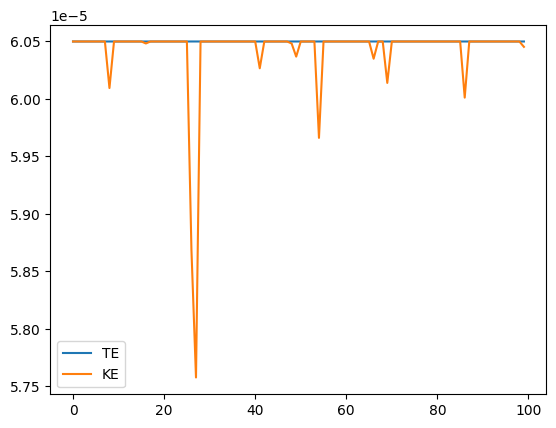

In [ ]:
plt.plot(ke + pe / 2, label='TE')
# plt.plot(ke, label='KE')
# plt.plot(pe, label='PE')
plt.legend()